# Machin learning(ML) y Dinámica Estructural

```
Autor       : Francisco Jimenez Mucho
Linkedin    : https://www.linkedin.com/in/fjmucho/
uppdate date: 7 Julio 2025
based on    : https://doi.org/10.1016/j.jcp.2018.10.045
```

## 1D harmonic oscillator Physics-informed neural networks (PINNs)

Read the seminal PINN papers [here](https://ieeexplore.ieee.org/document/712178), [here](https://www.sciencedirect.com/science/article/pii/S0021999118307125) and [blolog post](https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/).

### Descripcion del Problema | Problem overview.

En la figura se muestra el probelema a resolver relacionada con **Osilador harmónico amortiguado o del ingles damped harmonic oscillator**:

<center>
<img src="https://github.com/benmoseley/harmonic-oscillator-pinn-workshop/blob/main/oscillator.gif?raw=1" width="500">
</center>

We are interested in modelling the displacement of the mass on a spring (green box) over time.

This is a canonical physics problem, where the displacement, $u(t)$, of the oscillator as a function of time can be described by the following differential equation:

$$
m \dfrac{d^2 u}{d t^2} + \mu \dfrac{d u}{d t} + ku = 0~,
$$

where $m$ is the mass of the oscillator, $\mu$ is the coefficient of friction and $k$ is the spring constant.

We will focus on solving the problem in the **under-damped state**, i.e. where the oscillation is slowly damped by friction (as displayed in the animation above).

Mathematically, this occurs when:

$$
\delta < \omega_0~,~~~~~\mathrm{where}~~\delta = \dfrac{\mu}{2m}~,~\omega_0 = \sqrt{\dfrac{k}{m}}~.
$$

Furthermore, we consider the following initial conditions of the system:

$$
u(t=0) = 1~~,~~\dfrac{d u}{d t}(t=0) = 0~.
$$

For this particular case, the exact solution is known and given by:

$$
u(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{with}~~\omega=\sqrt{\omega_0^2 - \delta^2}~.
$$


<div class="alert alert-info">
  <strong>¡Información!</strong> For a more detailed mathematical description of the harmonic oscillator, check out this blog post because this problem was inspired by the following blog post: https://beltoforion.de/en/harmonic_oscillator/.
</div>


**Objetivos**
- Entrenar con algoritmos PINN desde cero con PyTorch, S1GDL de Dinamica Estructural.
- Comprender los diferentes usos en tareas cientificas con algoritmos PINNs y adoptar para otras.
- Comprender a detalle los algoritmos PINNs y como entrenar hasta encontrar su convergencia optima.

**Nuestra tarea**

Usar algoritmos PINN de PyTorch para resolver Ecuaciones de simulacion e inversioin relacionadas con el *Osiclador harmónico amoprtiguado*.

**Nuestro flujo de trabajo propuesto | Workflow overview**

The first part:

> First, we will train a standard neural network to interpolate a small part of the solution, using some observed training points from the solution.

> Next, we will train a PINN to extrapolate the full solution outside of these training points by penalising the underlying differential equation in its loss function.

There are **two scientific tasks** related to the harmonic oscillator we will use a PINN for:

> First, we will **simulate** the system using a PINN, given its initial conditions 

> Second, we will **invert** for underlying parameters of the system using a PINN, given some noisy observations of the oscillator's displacement.

> Finally, we will investigate how well the PINN **scales** to higher frequency oscillations and what can be done to improve its convergence.

**Configuraciones para el trabajo**

Usando Conda.
```bash
conda create -n workshop python=3
conda activate workshop
conda install jupyter numpy matplotlib
conda install pytorch torchvision torchaudio -c pytorch
```
usando google-colab o en local jupytter-notebook.
```bash

```

In [1]:
# !pip install numpy pandas tensorflow sklearn seaborn matplotlib -q

### 1 <img alt="pagakes" src="https://pypi.org/static/images/white-cube.2351a86c.svg" width="1%"/> Importacion de Librerias, clases, funciones, constantes, etc.

In [2]:
import os
import numpy as np
import pandas as pd

In [3]:
import torch
import torch.nn as nn

In [4]:
from PIL import Image

from matplotlib.ticker import AutoMinorLocator
import matplotlib.pyplot as plt
# import seaborn as sns

In [5]:
#  Configuracion de graficos
plt.style.use('default') # seaborn-v0.8
# plt.set_palette('deep')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10

#### 2.1. Funciones Utiles | Initial setup

In [6]:
def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)

def exact_solution_oscillator(d, w0, t):
    "Defines the analytical solution to the under-damped harmonic oscillator problem above."
    assert d < w0
    w   = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A   = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*t)
    exp = torch.exp(-d*t)
    u   = exp*2*A*cos
    return u

In [7]:
class FCN(nn.Module):
    "Defines a standard fully-connected network in PyTorch"

    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        """Metodo constructor"""
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(
                                *[nn.Linear(N_INPUT, N_HIDDEN), activation()]
                                )
        self.fch = nn.Sequential(
                                *[nn.Sequential( *[nn.Linear(N_HIDDEN, N_HIDDEN), activation()] ) for _ in range(N_LAYERS-1)]
                                )
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        """Metodo de tipo get: retorna ..."""
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

In [8]:
def check_dir_outputs(dirname):
    estado = None
    if os.path.exists(dirname) and os.path.isdir(dirname):
        # Verificando permisos de lectura, escritura y ejecución.
        if os.access(dirname, os.R_OK) and os.access(dirname, os.W_OK) and os.access(dirname, os.X_OK):
            estado = True
        else:
            estado = False
            print(f"El directorio '{dirname}' no tiene todos los permisos necesarios.")
    else:
        os.makedir('outputs' )
    return estado

### 2. Carga y preparacion de datos (data)

Para esto usamos $\delta=2$, $\omega_0=20$, y intentaremos que aprenda la solucion en de dominio $x\in[0,1]$

In [9]:
d, w0 = 2, 20

# get the analytical solution over the full domain
x = torch.linspace(0,1,500).view(-1,1)
y = exact_solution_oscillator(d, w0, x).view(-1,1)
print(x.shape, y.shape)

# slice out a small number of points from the LHS of the domain
x_data = x[0:200:20]
y_data = y[0:200:20]
print(x_data.shape, y_data.shape)

torch.Size([500, 1]) torch.Size([500, 1])
torch.Size([10, 1]) torch.Size([10, 1])


In [10]:
data = pd.DataFrame(np.concatenate((x, y), axis=1), columns=['Tiempo','registro'])
data.head()

,Tiempo,registro
0,0.000000,1.000000
1,0.002004,0.999199
2,0.004008,0.996806
3,0.006012,0.992837
4,0.008016,0.987312


### 3. Pre-Calculos de la data 

In [11]:
display(data.info())

# print(f"variables: {data.columns.tolist()}\n")

# print(f"tipos de datos:\n{data.dtypes}\n")

# print(f"Valores nulos por columna:\n{data.isnull().sum()}\n")

# data_keys = data_temp.keys()
data_keys = data.columns.tolist()
data_keys

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Tiempo    500 non-null    float32
 1   registro  500 non-null    float32
dtypes: float32(2)
memory usage: 4.0 KB


None

['Tiempo', 'registro']

In [12]:
data.describe().round(2).transpose()

,count,mean,std,min,25%,50%,75%,max
Tiempo,500.0,0.50,0.29,0.00,0.25,0.50,0.75,1.0
registro,500.0,0.02,0.36,-0.73,-0.20,0.03,0.22,1.0


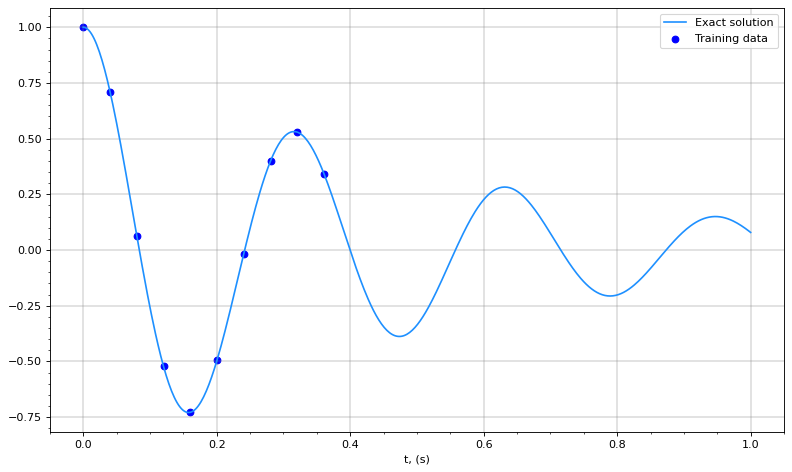

In [13]:
fig, ax = plt.subplots(1,1, dpi=80)

ax.plot(x, y, label="Exact solution", color='dodgerblue')
ax.scatter(x_data, y_data, color="blue", label="Training data")
ax.set_xlabel('t, (s)')
ax.legend()

# Apply AutoMinorLocator with 5 subdivisions between major ticks
minor_locator = AutoMinorLocator(5)
ax.xaxis.set_minor_locator(minor_locator)
ax.yaxis.set_minor_locator(minor_locator)

ax.grid( linewidth=0.4, color='gray')

plt.tight_layout()
plt.show()

### 4. Entrenamiento

#### 4.1 Normal neural network

> Next, we train a standard neural network (fully connected network) to fit these training points.

> We find that the network is able to fit the solution very closely in the vicinity of the training points, but does not learn an accurate solution outside of them.

In [17]:
def plot_result(i, x,y,x_data,y_data,yh,xp=None):
    plt.figure(dpi=80, figsize=(8,4))

    plt.plot(x,y, color="dodgerblue", linewidth=1.5, alpha=0.8, label="Exact solution")
    plt.plot(x,yh, color="blue", linewidth=1.3, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data, y_data, s=60, color="cyan", edgecolor='magenta', alpha=0.4, label='Training data')

    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=60, color="blue", alpha=0.4, 
                    label='Physics loss training locations')
    
    # localizar_en =(1.01,0.34)
    localizar_en = 'upper right' # 'best', 'upper right', 'upper left', 'lower left', 'lower right', 'center left', 'center right', 'lower center', 'upper center'
    l = plt.legend( loc=localizar_en, frameon=False, fontsize="large" )
    plt.setp(l.get_texts(), color="k")

    # plt.xlim(-0.05, 1.05)
    # plt.ylim(-1.1, 1.1)

    plt.title("Training step: %i"%(i+1), fontsize="xx-large")
    # plt.text(1.065,0.7,"Training step: %i"%(i+1),fontsize="xx-large",color="k")

    plt.grid()
    # plt.axis("off")
    

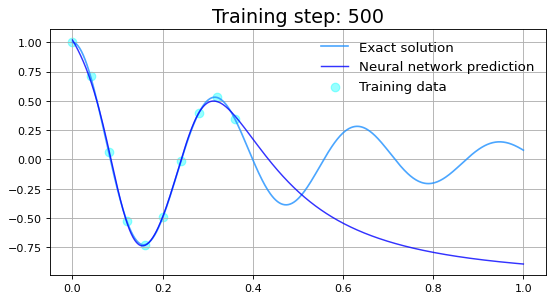

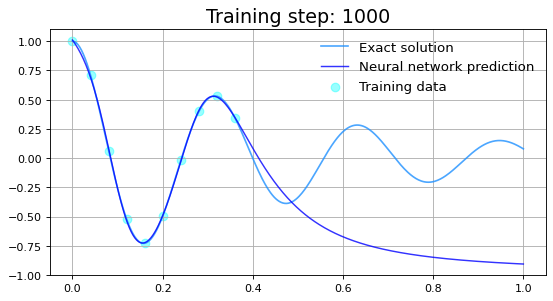

In [15]:
ruta_directorio_outs = 'outputs' # for save images and data

# train standard neural network to fit training data
torch.manual_seed(123)
model = FCN(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

files = []
for i in range(1000):
    optimizer.zero_grad()
    yh = model(x_data)
    loss = torch.mean((yh-y_data)**2)# use mean squared error
    loss.backward()
    optimizer.step()
    
    
    # plot the result as training progresses
    if (i+1) % 10 == 0: 
        
        yh = model(x).detach()
        
        plot_result(i, x,y,x_data,y_data,yh)
      
        # if check_dir_outputs(ruta_directorio_outs):
        #     file = "outputs/nn_%.8i.png"%(i+1)
        #     plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        #     files.append(file)
    
        if (i+1) % 500 == 0: plt.show()
        else: plt.close("all")
            
# save_gif_PIL("outputs/nn.gif", files, fps=20, loop=0)

#### 4.2 PINN

> Finally, we add the underlying differential equation ("physics loss") to the loss function.

The physics loss aims to ensure that the learned solution is consistent with the underlying differential equation. This is done by penalising the residual of the differential equation over a set of locations sampled from the domain.

Here we evaluate the physics loss at 30 points uniformly spaced over the problem domain $([0,1])$. We can calculate the derivatives of the network solution with respect to its input variable at these points using `pytorch's` autodifferentiation features, and can then easily compute the residual of the differential equation using these quantities.

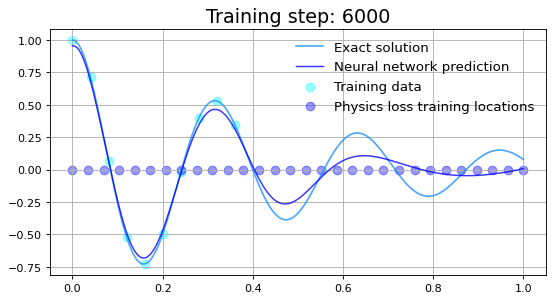

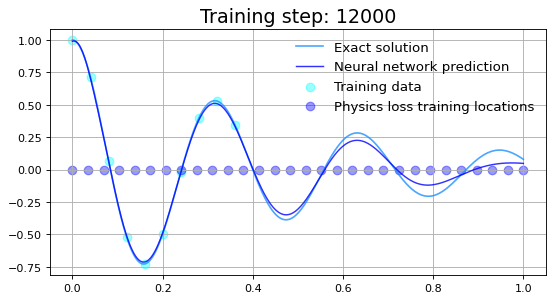

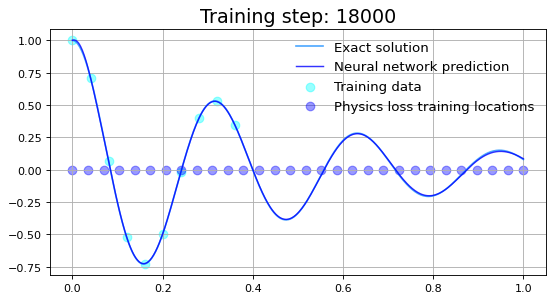

In [16]:
x_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)# sample locations over the problem domain
mu, k = 2*d, w0**2

torch.manual_seed(123)
model = FCN(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)

files = []
for i in range(20000):
    optimizer.zero_grad()
    
    # compute the "data loss"
    yh = model(x_data)
    loss1 = torch.mean((yh-y_data)**2)# use mean squared error
    
    # compute the "physics loss"
    yhp = model(x_physics)
    dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx
    dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]# computes d^2y/dx^2
    physics = dx2 + mu*dx + k*yhp# computes the residual of the 1D harmonic oscillator differential equation
    loss2 = (1e-4)*torch.mean(physics**2)
    
    # backpropagate joint loss
    loss = loss1 + loss2# add two loss terms together
    loss.backward()
    optimizer.step()
    
    
    # plot the result as training progresses
    if (i+1) % 150 == 0: 
        
        yh = model(x).detach()
        xp = x_physics.detach()
        
        plot_result(i, x,y,x_data,y_data,yh,xp)
        
        # if check_dir_outputs(ruta_directorio_outs):
        #     file = "outputs/pinn_%.8i.png"%(i+1)
        #     plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        #     files.append(file)
        
        if (i+1) % 6000 == 0: plt.show()
        else: plt.close("all")
            
# save_gif_PIL("outputs/pinn.gif", files, fps=20, loop=0)

### Task 1: train a PINN to simulate the system

#### Task

The first task is to use a PINN to **simulate** the system.

Specifically, our inputs and outputs are:

- Inputs: underlying differential equation and the initial conditions of the system
- Outputs: estimate of the solution, $u(t)$

#### Approach

The PINN is trained to directly approximate the solution to the differential equation, i.e.

$$
u_{\mathrm{PINN}}(t;\theta) \approx u(t)~,
$$

where $\theta$ are the free parameters of the PINN.

#### Loss function

To simulate the system, the PINN is trained with the following loss function:

$$
\mathcal{L}(\theta)= (u_{\mathrm{PINN}}(t=0;\theta) - 1)^2 + \lambda_1 \left(\frac{d\,u_{\mathrm{PINN}}}{dt}(t=0;\theta) - 0\right)^2 + \frac{\lambda_2}{N} \sum^{N}_{i} \left( \left[ m\frac{d^2}{dt^2} + \mu \frac{d}{dt} + k \right] u_{\mathrm{PINN}}(t_{i};\theta)  \right)^2
$$

For this task, we use $\delta=2$, $\omega_0=20$, and try to learn the solution over the domain $t\in [0,1]$.

#### Notes

The first two terms in the loss function represent the **boundary loss**, and tries to ensure that the solution learned by the PINN matches the initial conditions of the system, namely, $u(t=0)=1$ and $u'(t=0)=0$.

The second term in the loss function is called the **physics loss**, and and tries to ensure that the PINN solution obeys the underlying differential equation at a set of training points $\{t_i\}$ sampled over the entire domain.

The hyperparameters, $\lambda_1$ and $\lambda_2$, are used to balence the terms in the loss function, to ensure stability during training.

Autodifferentiation (`torch.autograd`) is used to calculate the gradients of the PINN with respect to its input required to evaluate the loss function. This is very powerful!

For more details on `torch.autograd`, check out [this](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#a-gentle-introduction-to-torch-autograd) tutorial.

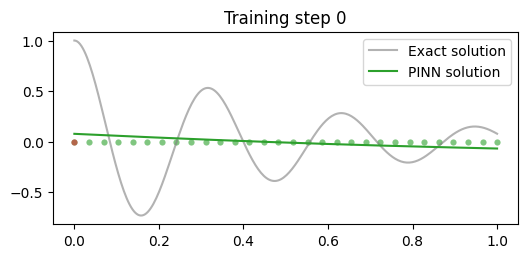

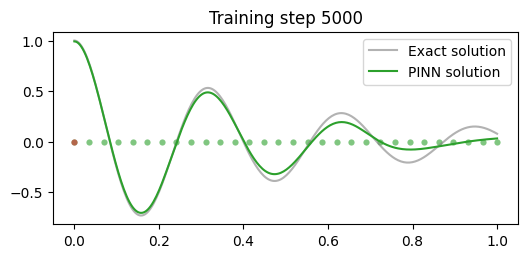

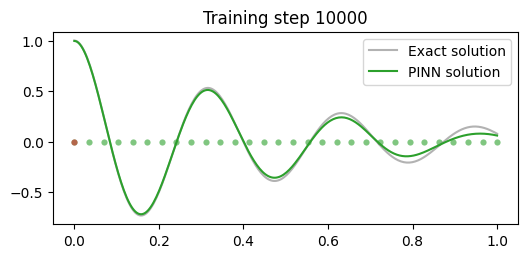

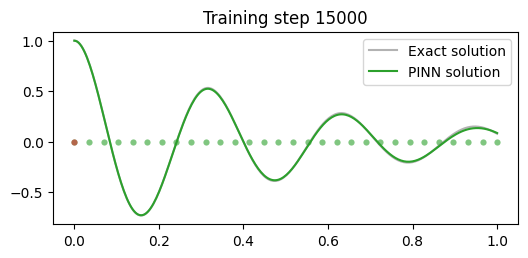

In [18]:
torch.manual_seed(123)

# define a neural network to train
# TODO: write code here
pinn = FCN(1,1,32,3)

# define boundary points, for the boundary loss
# TODO: write code here
t_boundary = torch.tensor(0.).view(-1,1).requires_grad_(True)

# define training points over the entire domain, for the physics loss
# TODO: write code here
t_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)

# train the PINN
d, w0 = 2, 20
mu, k = 2*d, w0**2
t_test = torch.linspace(0,1,300).view(-1,1)
u_exact = exact_solution_oscillator(d, w0, t_test)
optimiser = torch.optim.Adam(pinn.parameters(),lr=1e-3)
for i in range(15001):
    optimiser.zero_grad()

    # compute each term of the PINN loss function above
    # using the following hyperparameters:
    lambda1, lambda2 = 1e-1, 1e-4

    # compute boundary loss
    # TODO: write code here
    u = pinn(t_boundary)
    loss1 = (torch.squeeze(u) - 1)**2
    dudt = torch.autograd.grad(u, t_boundary, torch.ones_like(u), create_graph=True)[0]
    loss2 = (torch.squeeze(dudt) - 0)**2

    # compute physics loss
    # TODO: write code here
    u = pinn(t_physics)
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]
    loss3 = torch.mean((d2udt2 + mu*dudt + k*u)**2)

    # backpropagate joint loss, take optimiser step
    # TODO: write code here
    loss = loss1 + lambda1*loss2 + lambda2*loss3
    loss.backward()
    optimiser.step()

    # plot the result as training progresses
    if i % 5000 == 0:
        #print(u.abs().mean().item(), dudt.abs().mean().item(), d2udt2.abs().mean().item())
        u = pinn(t_test).detach()

        plt.figure( figsize=(6,2.5) )        
        plt.scatter(t_physics.detach()[:,0],
                    torch.zeros_like(t_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
        plt.scatter(t_boundary.detach()[:,0],
                    torch.zeros_like(t_boundary)[:,0], s=20, lw=0, color="red", alpha=0.8)
        plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
        plt.plot(t_test[:,0], u[:,0], label="PINN solution", color="tab:green")
        plt.title( f"Training step {i}" )
        plt.legend()
        plt.show()

### Task 2: train a PINN to invert for underlying parameters

#### Task

The second task is to use a PINN to **invert** for underlying parameters.

Specifically, our inputs and outputs are:

- Inputs: noisy observations of the oscillator's displacement
- Outputs: estimate $\mu$, the coefficient of friction

#### Approach

Similar to above, the PINN is trained to directly approximate the solution to the differential equation, i.e.

$$
u_{\mathrm{PINN}}(t;\theta) \approx u(t)~,
$$

where $\theta$ are the free parameters of the PINN.

The key idea here is to also treat $\mu$ as a **learnable parameter** when training the PINN - so that we both simulate the solution and invert for this parameter.

#### Loss function

The PINN is trained with a slightly different loss function:

$$
\mathcal{L}(\theta, \mu)= \frac{1}{N} \sum^{N}_{i} \left( \left[ m\frac{d^2}{dt^2} + \mu \frac{d}{dt} + k \right] u_{\mathrm{PINN}}(t_{i};\theta)  \right)^2 + \frac{\lambda}{M} \sum^{M}_{j} \left( u_{\mathrm{PINN}}(t_{j};\theta) - u_{\mathrm{obs}}(t_{j}) \right)^2
$$

#### Notes

There are two terms in the loss function here. The first is the **physics loss**, formed in the same way as above, which ensures the solution learned by the PINN is consistent with the know physics.

The second term is called the **data loss**, and makes sure that the solution learned by the PINN fits the (potentially noisy) observations of the solution that are available.

Note, we have removed the boundary loss terms, as we do not know these (i.e., we are only given the observed measurements of the system).

In this set up, the PINN parameters $\theta$ and $\mu$ are **jointly** learned during optimisation.

Again, autodifferentiation is our friend and will allow us to easily define this problem!

True value of mu: 4


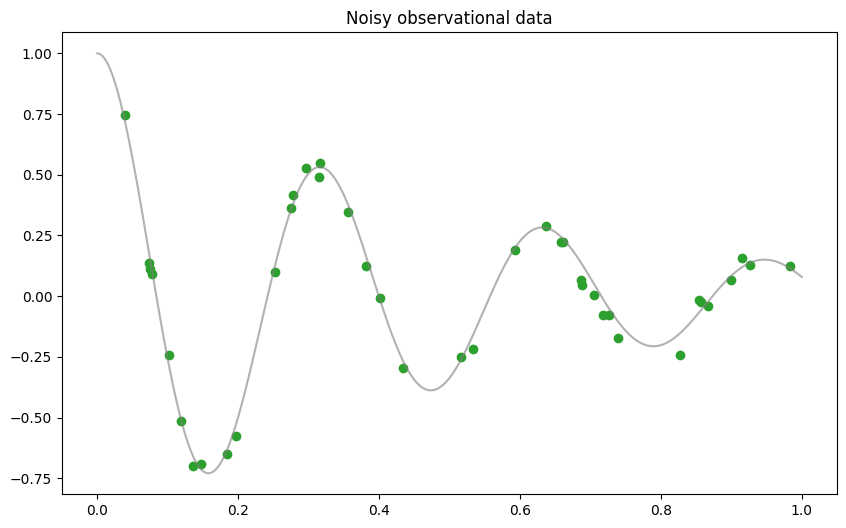

In [24]:
# first, create some noisy observational data
torch.manual_seed(123)
d, w0 = 2, 20
print(f"True value of mu: {2*d}")
t_obs = torch.rand(40).view(-1,1)
u_obs = exact_solution_oscillator(d, w0, t_obs) + 0.04*torch.randn_like(t_obs)

plt.figure(dpi=100)
plt.title("Noisy observational data")
plt.scatter(t_obs[:,0], u_obs[:,0], color='tab:green')
t_test, u_exact = torch.linspace(0,1,300).view(-1,1), exact_solution_oscillator(d, w0, t_test)
plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
plt.show()

<>:59: SyntaxWarning: invalid escape sequence '\m'
<>:59: SyntaxWarning: invalid escape sequence '\m'
C:\Users\inOut\AppData\Local\Temp\ipykernel_6240\2224927731.py:59: SyntaxWarning: invalid escape sequence '\m'
  plt.title("$\mu$")


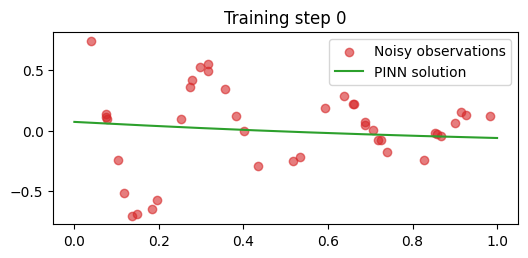

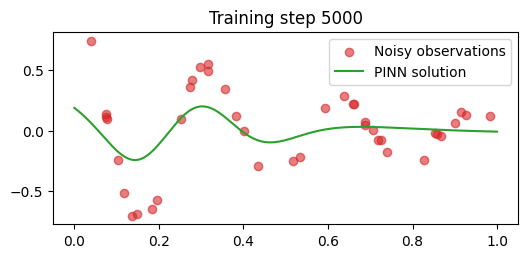

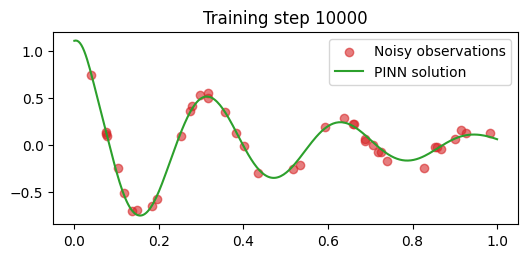

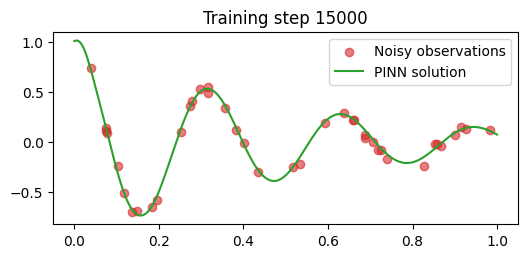

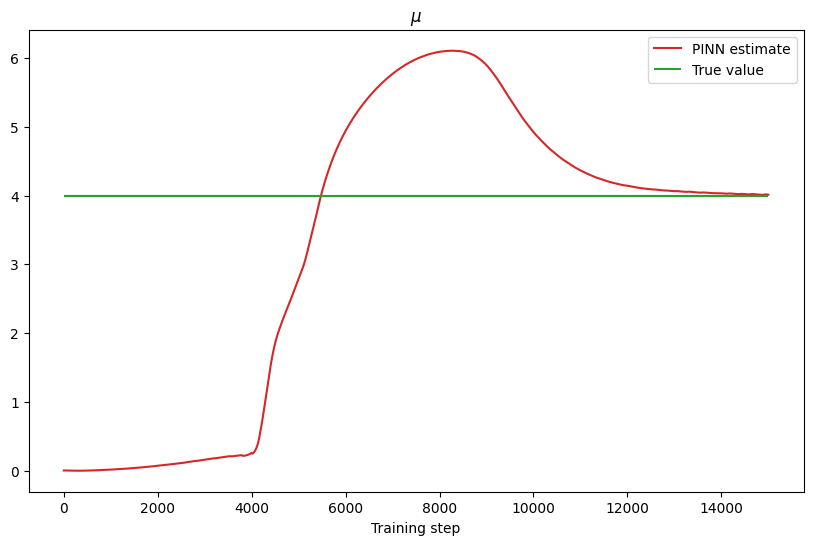

In [25]:
torch.manual_seed(123)

# define a neural network to train
pinn = FCN(1,1,32,3)

# define training points over the entire domain, for the physics loss
t_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)

# train the PINN
d, w0 = 2, 20
_, k = 2*d, w0**2

# treat mu as a learnable parameter
# TODO: write code here
mu = torch.nn.Parameter(torch.zeros(1, requires_grad=True))
mus = []

# add mu to the optimiser
# TODO: write code here
optimiser = torch.optim.Adam(list(pinn.parameters())+[mu],lr=1e-3)
for i in range(15001):
    optimiser.zero_grad()

    # compute each term of the PINN loss function above
    # using the following hyperparameters:
    lambda1 = 1e4

    # compute physics loss
    u = pinn(t_physics)
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]
    loss1 = torch.mean((d2udt2 + mu*dudt + k*u)**2)

    # compute data loss
    # TODO: write code here
    u = pinn(t_obs)
    loss2 = torch.mean((u - u_obs)**2)

    # backpropagate joint loss, take optimiser step
    loss = loss1 + lambda1*loss2
    loss.backward()
    optimiser.step()

    # record mu value
    # TODO: write code here
    mus.append(mu.item())

    # plot the result as training progresses
    if i % 5000 == 0:
        u = pinn(t_test).detach()
        plt.figure(figsize=(6,2.5))
        plt.scatter(t_obs[:,0], u_obs[:,0], label="Noisy observations", alpha=0.6, color='tab:red')
        plt.plot(t_test[:,0], u[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()

plt.figure()
plt.title("$\mu$")
plt.plot(mus, label="PINN estimate", color='tab:red')
plt.hlines(2*d, 0, len(mus), label="True value", color="tab:green")
plt.legend()
plt.xlabel("Training step")
plt.show()

### Task 3: investigate how well the PINN scales to higher frequency oscillations

#### Task

The final task is to investigate how well the PINN **scales** to higher frequency oscillations and what can be done to improve its convergence.

Specifically, we go back to simulating the solution to the harmonic oscillator, and increase its frequency, $\omega_0$.

#### To do

>To do: Go back to Task 1 above, and see what happens when you **increase** $\omega_0$ from 20 to 80.

You should find that the PINN struggles to converge, even if the number of physics training points is increased.

This is a harder problem for the PINN to solve, in part because of the **spectral bias** of neural networks, as well as the fact more training points are required.

#### Approach: alternative "ansatz" formulation

To speed up convergence, one way is to **assume something** about the solution.

For example, suppose we know from our physics intuition that the solution is in fact sinusodial.

Then, instead of having the PINN directly approximate the solution to the differential equation, i.e.

$$
u_{\mathrm{PINN}}(t;\theta) \approx u(t)~,
$$

We instead use the PINN as part of a mathematical ansatz of the solution, i.e.

$$
\hat u(t; \theta, \alpha, \beta) = u_{\mathrm{PINN}}(t;\theta)  \sin (\alpha t + \beta) \approx u(t)~,
$$

where $\alpha, \beta$ are treated as additional learnable parameters.

Comparing this ansatz to the exact solution

$$
u(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))
$$

We see that now the PINN only needs to learn the exponential function, which should be a much easier problem.

Again, autodifferentiation allows us to easily differentiate through this ansatz to train the PINN!

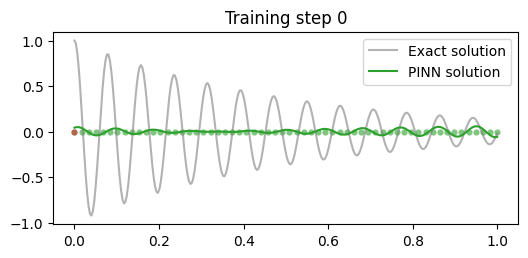

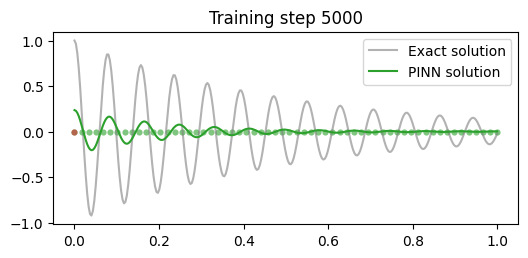

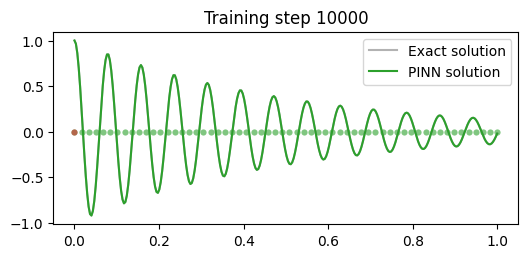

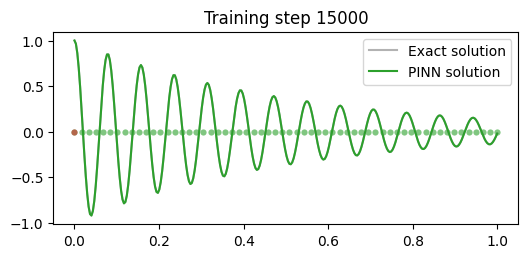

In [ ]:
torch.manual_seed(123)

# define a neural network to train
pinn = FCN(1,1,32,3)

# define additional a,b learnable parameters in the ansatz
# TODO: write code here
a = torch.nn.Parameter(70*torch.ones(1, requires_grad=True))
b = torch.nn.Parameter(torch.ones(1, requires_grad=True))

# define boundary points, for the boundary loss
t_boundary = torch.tensor(0.).view(-1,1).requires_grad_(True)

# define training points over the entire domain, for the physics loss
t_physics = torch.linspace(0,1,60).view(-1,1).requires_grad_(True)

# train the PINN
d, w0 = 2, 80# note w0 is higher!
mu, k = 2*d, w0**2
t_test = torch.linspace(0,1,300).view(-1,1)
u_exact = exact_solution_oscillator(d, w0, t_test)

# add a,b to the optimiser
# TODO: write code here
optimiser = torch.optim.Adam(list(pinn.parameters())+[a,b],lr=1e-3)
for i in range(15001):
    optimiser.zero_grad()

    # compute each term of the PINN loss function above
    # using the following hyperparameters:
    lambda1, lambda2 = 1e-1, 1e-4

    # compute boundary loss
    # TODO: write code here (change to ansatz formulation)
    u = pinn(t_boundary)*torch.sin(a*t_boundary+b)
    loss1 = (torch.squeeze(u) - 1)**2
    dudt = torch.autograd.grad(u, t_boundary, torch.ones_like(u), create_graph=True)[0]
    loss2 = (torch.squeeze(dudt) - 0)**2

    # compute physics loss
    # TODO: write code here (change to ansatz formulation)
    u = pinn(t_physics)*torch.sin(a*t_physics+b)
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]
    loss3 = torch.mean((d2udt2 + mu*dudt + k*u)**2)

    # backpropagate joint loss, take optimiser step
    # TODO: write code here
    loss = loss1 + lambda1*loss2 + lambda2*loss3
    loss.backward()
    optimiser.step()

    # plot the result as training progresses
    if i % 5000 == 0:
        #print(u.abs().mean().item(), dudt.abs().mean().item(), d2udt2.abs().mean().item())
        u = (pinn(t_test)*torch.sin(a*t_test+b)).detach()
        plt.figure(figsize=(6,2.5))
        plt.scatter(t_physics.detach()[:,0],
                    torch.zeros_like(t_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
        plt.scatter(t_boundary.detach()[:,0],
                    torch.zeros_like(t_boundary)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
        plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
        plt.plot(t_test[:,0], u[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()

### Extensions



PINNs have been extended and improved in many ways since they have been proposed. Some things to try are:

- Try PINNs out for a different differential equation
- Try extending them to higher dimensions (e.g. 2D and 3D simulations)
- See how far you can push the inversion task: can you discover $m$, $\mu$ and $k$ simultaneously (and therefore, discover the entire underlying equation?)

## Referencias.

1. Chapra, S. C., & Canale, R. P. (2010). Numerical Methods for Engineers (6th ed.). MCGraw-Hill Education.
2. https://github.com/benmoseley/harmonic-oscillator-pinn/tree/main, https://github.com/benmoseley/harmonic-oscillator-pinn-workshop/tree/main